### Mount on drive and set git

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%cd /content/drive/MyDrive/Git-Glonet_thinfilm/GLOnet_for_SDPC

/content/drive/MyDrive/Git-Glonet_thinfilm/GLOnet_for_SDPC


In [9]:
!git status

Refresh index: 100% (36/36), done.
On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   Fig4b.png
	modified:   SDPC_optim.ipynb
	modified:   TMM.py
	modified:   __pycache__/GLOnet_thinfilm.cpython-310.pyc
	modified:   __pycache__/TMM.cpython-310.pyc
	modified:   __pycache__/material_database.cpython-310.pyc
	modified:   __pycache__/net.cpython-310.pyc
	modified:   material_database.py
	modified:   net.py

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	material_database/mat_MoSe2.xlsx

no changes added to commit (use "git add" and/or "git commit -a")


In [10]:
!git config --global user.email "fatemefarhang2048@gmail.com"
!git config --global user.name "FatemeFarhang"

In [ ]:
!git add .
!git commit -m "GPU friendly/ theta= 0"

[master 2b30851] GPU friendly/ theta= 0
 8 files changed, 55 insertions(+), 65 deletions(-)
 rewrite Fig4b.png (98%)
 rewrite SDPC_optim.ipynb (95%)
 rewrite __pycache__/GLOnet_thinfilm.cpython-310.pyc (73%)
 rewrite __pycache__/net.cpython-310.pyc (92%)


In [ ]:
!git commit --amend -m "correct learning / low speed"

[master 01fb9a8] correct learning / low speed
 Date: Sun May 28 20:23:33 2023 +0000
 8 files changed, 55 insertions(+), 65 deletions(-)
 rewrite Fig4b.png (98%)
 rewrite SDPC_optim.ipynb (95%)
 rewrite __pycache__/GLOnet_thinfilm.cpython-310.pyc (73%)
 rewrite __pycache__/net.cpython-310.pyc (92%)


In [ ]:
!git push

Enumerating objects: 19, done.
Counting objects: 100% (19/19), done.
Delta compression using up to 2 threads
Compressing objects: 100% (11/11), done.
Writing objects: 100% (11/11), 325.75 KiB | 9.05 MiB/s, done.
Total 11 (delta 5), reused 0 (delta 0)
remote: Resolving deltas: 100% (5/5), completed with 5 local objects.
To https://github.com/FatemeFarhang/GLOnet_for_SDPC.git
   7fad42b..01fb9a8  master -> master


### Import libraries and packages


In [2]:
from matplotlib import rcParams, rc
rcParams.update({'figure.autolayout': True})
import torch
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import math
from utils import Params
from tqdm import tqdm
from IPython.display import HTML
from IPython.display import Image
from TMM import *
from material_database import MatDatabase
from GLOnet_thinfilm import GLOnet
import scipy.io as io

from scipy.optimize import fsolve

In [3]:
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 19
plt.rc('figure', figsize=(6,5))
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

### Set the initial parameters and hyperparameters

In [4]:
Vis = [0.4, 0.7]
params = Params()
params.pol = 'TM'
params.k =  2 * math.pi / torch.cat([torch.linspace(0.3, Vis[0], 10), torch.linspace(Vis[0], Vis[1], 50), torch.linspace(Vis[1], 1.5, 90), torch.linspace(1.5, 2.5, 80)])
params.theta = torch.tensor([0.])
params.n_top = torch.tensor([1.])
params.n_bot = torch.tensor([1.])
# params.max_l = 8
params.thicknesses = torch.tensor([.07, .08, .1, .1])

params.nums = torch.linspace(2, 21, 20, dtype=torch.int)
params.user_define = False
## choose from material database
params.materials = ['SiN', 'SiO2', 'MoSe2']
params.matdatabase = MatDatabase(params.materials)
params.n_database = params.matdatabase.interp_wv(2 * math.pi/params.k) # number of materials x number of frequencies

params.target_reflection = torch.zeros(params.k.size(0))#torch.ones((1, params.k.size(0), 1, 1)) # 1 x number of frequencies x number of angles x (number of pol or 1)
params.target_reflection[10:60] = 1
params.thickness_sup = 0.3 # [um]
params.alpha_sup = .0001

# params.net = 'DNN'
params.res_layers = 8
params.res_dim = 64
params.noise_dim = 4

params.lr = 0.01
params.beta1 = 0.9
params.beta2 = 0.95
params.weight_decay = 0.001
params.step_size = 10000
params.gamma = 0.5
params.numIter = 300
params.batch_size = 30
params.sigma = 0.2

### Dispersion input data for $SiO_{2}$ and $SiN$

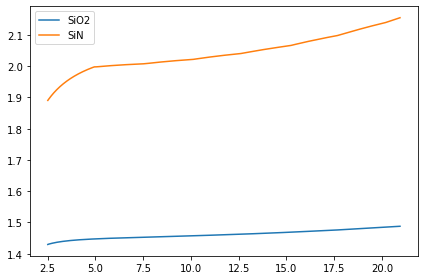

In [ ]:
plt.plot(params.k,params.n_database[0].cpu(), label='SiO2')
plt.plot(params.k,params.n_database[1].cpu(), label='SiN')
plt.legend(loc=0)

### Train the Resnet

100%|██████████| 300/300 [14:49<00:00,  2.96s/it]


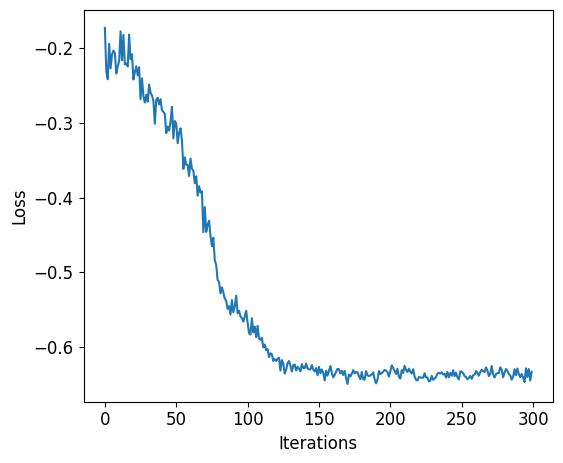

In [5]:
results = []
for i in range(1):
    glonet = GLOnet(params)
    glonet.train()
    glonet.viz_training()
    glonet.generator.eval()

    (m, n, b, reflection) = glonet.evaluate(50, kvector = params.k, inc_angles = params.theta, pol = 'TM',
                                                                                grayscale=False)
### Mean Squared Error:
    # FoM = torch.pow(reflection - params.target_reflection.cuda(), 2).mean(dim=[1, 2, 3])
    # _, indices = torch.sort(FoM)
    # opt_idx = indices[0]
    # results.append(FoM[opt_idx])

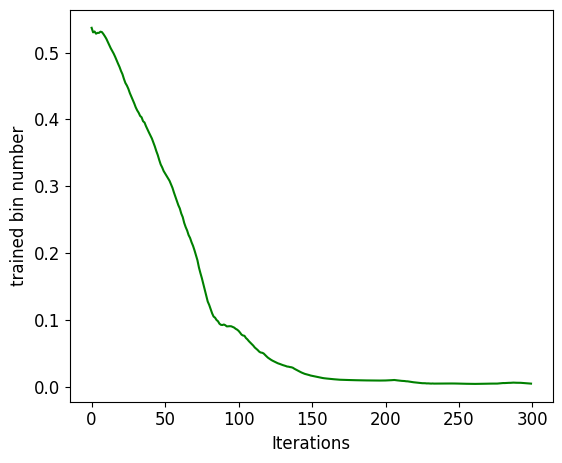

In [6]:
plt.plot(torch.tensor(glonet.b_training).cpu(), 'g')
plt.ylabel('trained bin number')
plt.xlabel('Iterations')
plt.show()

The FoM of the optimum device: tensor(0.0623, dtype=torch.float64)


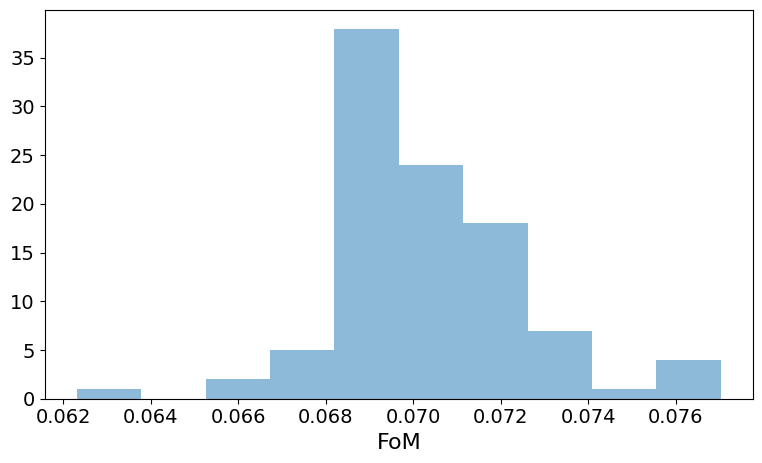

In [7]:
with torch.no_grad():
    params.k_test = 2 * math.pi / torch.linspace(0.3, 2.5, 400)
    # params.n_database = params.matdatabase.interp_wv(2 * math.pi/params.k_test)
    # params.theta_test = torch.linspace(0, math.pi/2.25, 200)
    glonet.generator.eval()
    (m, n, b, reflection) = glonet.evaluate(100, kvector = params.k_test, pol = 'TE',
                                                                                grayscale=False)

    params.target_reflection = torch.zeros(params.k_test.size(0)) # 1 x number of frequencies x number of angles x (number of pol or 1)
    dx = (2.5-0.3)/400
    idx_start = round((Vis[0]-0.3)/dx)
    idx_end = round((Vis[1]-0.3)/dx)
    params.target_reflection[idx_start:idx_end] = 1


    FoM = torch.pow(reflection - params.target_reflection, 2).mean(dim=1)
    _, indices = torch.sort(FoM)
    opt_idx = indices[0]


    plt.figure(figsize=(8,5))
    plt.hist(FoM.cpu().detach().numpy(), alpha = 0.5)
    plt.xlabel('FoM', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    print("The FoM of the optimum device:",FoM[opt_idx])

    m_opt = m[opt_idx]
    b_opt = b[opt_idx]
    # mat_opt = [params.materials[result_mat[opt_idx, i]] for i in range(result_mat.size(1))]

These are the average errors for a set of 100 reflection profiles from the target profile.
So the most common error was 0.07.

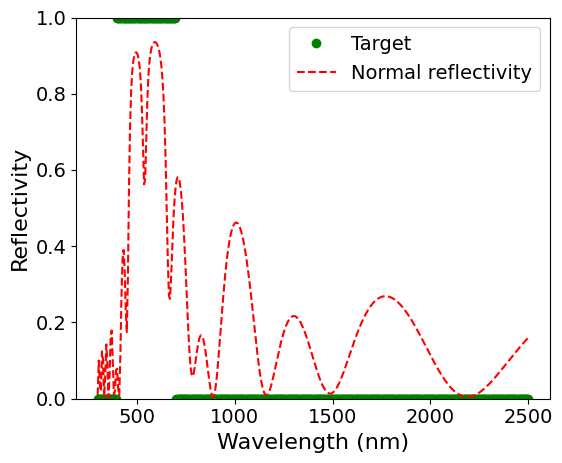

In [8]:
params.k_test = 2 * math.pi / torch.linspace(0.3, 2.5, 400)
params.theta_test = params.theta #torch.linspace(0, math.pi/2.25, 200)
reflection_opt = TMM_solver(m[opt_idx].unsqueeze(-1),
                   n[opt_idx].unsqueeze(-1),
                   b[opt_idx].unsqueeze(-1),
                   thickness = params.thicknesses,
                   refractive_indices = params.matdatabase.interp_wv(2 * math.pi/params.k_test),
                   n_bot = params.n_bot,
                   n_top = params.n_top,
                   k = params.k_test,
                #    inc_angles = params.theta_test,
                   theta = params.theta,
                   pol = 'TM')

# params.target_reflection = torch.zeros((1, params.k_test.size(0), 1, 1)) # 1 x number of frequencies x number of angles x (number of pol or 1)
dx = (2.5-0.3)/400
idx_start = round((Vis[0]-0.3)/dx)
idx_end = round((Vis[1]-0.3)/dx)
# params.target_reflection[:, idx_start:idx_end, :, :] = 1

# dtheta = params.theta_test[1] - params.theta_test[0]
# aver_reflection = torch.sum(reflection_opt.mean(dim=2) * torch.sin(2 * params.theta_test).view(1,-1), dim=1) * dtheta

# plot
plt.plot(2*math.pi/params.k_test*1000, params.target_reflection, 'go')
plt.plot(2*math.pi/params.k_test*1000, reflection_opt.cpu().view(-1), '--r', )
# plt.plot(2*math.pi/params.k_test*1000, aver_reflection.view(-1).numpy(), '-b')
plt.ylabel('Reflectivity', fontsize=16)
plt.xlabel('Wavelength (nm)', fontsize=16)
plt.ylim(0, 1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(['Target','Normal reflectivity', 'Average reflectivity'], fontsize = 14)
plt.savefig('Fig4b.png', dpi=300)